---
title: Homework 04
---

> For a day/time of interest (different from the notes) from THEMIS or MMS (or RBSP or other), based on your perusal of the overview plots at the mission website, and using standard tools:
>
> - Obtain EFI data in spinning and despun spacecraft coord’s and in some geophysical (e.g., GSE or GSM) coord’s. 
> - Using the data in DSL or DMPA coordinates (where XY are despun, spin-plane components) estimate the offset in X and Y from a quiet time in the magnetosphere when the flows, and hence –VxB, are expected to be slow. Remove the offset from the data.
> - With the spin plane offsets removed, obtain the 3rd component (Z) for times when the Bfield is at a large angle relative to the spin plane (>10deg or more) using the E*B=0 approximation. 
> - Compare your estimate of Ez with the measurement of the same component made by the axial electric field boom pair. How large are the offsets for the axial field compared to those you have found for the spin plane components? 
> 
> Note: A crib sheet and a jupyter notebook on how to perform the offset removal and EdotB determination are my_thm_efi_load_cal_crib.pyspd and my_thm_efi_load_cal_crib.py, located in the class notes below Lecture 12. Use a different spacecraft for your solution. A good day for THEMIS is another spacecraft from the first Science paper (2008-02-26 4-6UT)– except TH-D which is in the released crib sheet. A good day for MMS is the first Science [paper](https://www.science.org/doi/10.1126/science.aaf2939) (2015-10-16 13:05-13:08UT) from any of the four MMS spacecraft.


We choose MMS for this question. And the data is from 2015-10-16 13:00-14:00UT.

Its overall summary plot together with SCM quicklook plots are shown below.

![MMS Overall Summary](https://lasp.colorado.edu/mms/sdc/public/data/sdc/ql/all_mms1_summ/2015/10/16/ql_all_mms1_summ_20151016_1200_0120.png){width=50%}

## Quickplot

In [174]:
#| code-fold: true
import pyspedas
from pytplot import tplot, get_data, tlimit

import xarray as xr
import numpy as np

28-Nov-23 17:11:35: Loading /Users/zijin/data/mms/mms1/edp/fast/l2/dce/2015/10/mms1_edp_fast_l2_dce_20151016_v2.1.0.cdf
28-Nov-23 17:11:37: Time clip was applied to: mms1_edp_dce_gse_fast_l2
28-Nov-23 17:11:38: Time clip was applied to: mms1_edp_dce_dsl_fast_l2
28-Nov-23 17:11:38: Time clip was applied to: mms1_edp_dce_par_epar_fast_l2
28-Nov-23 17:11:38: Loaded variables:
28-Nov-23 17:11:38: mms1_edp_dce_gse_fast_l2
28-Nov-23 17:11:38: mms1_edp_dce_dsl_fast_l2
28-Nov-23 17:11:38: mms1_edp_dce_par_epar_fast_l2


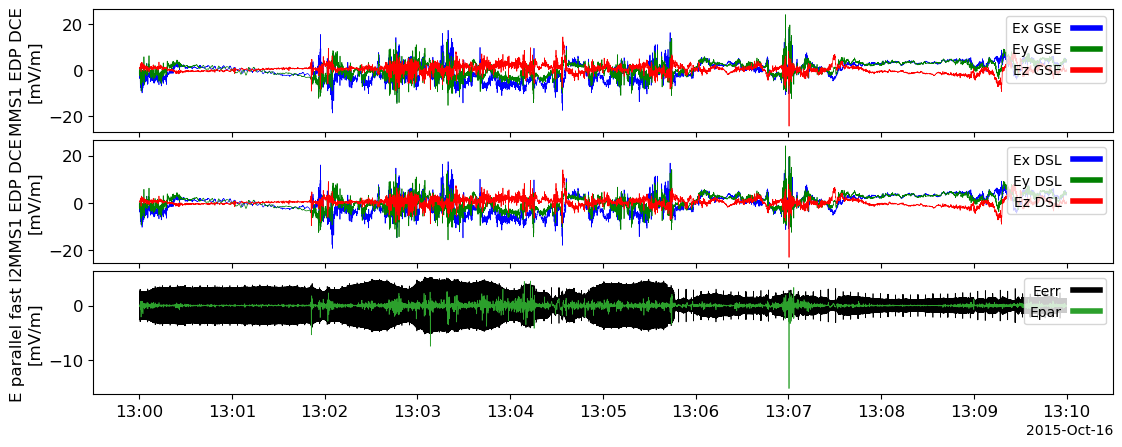

In [175]:
trange = ['2015-10-16T13:00:00', '2015-10-16T13:10:00']
tvars = pyspedas.mms.edp(trange=trange, time_clip=True)
tplot(tvars)

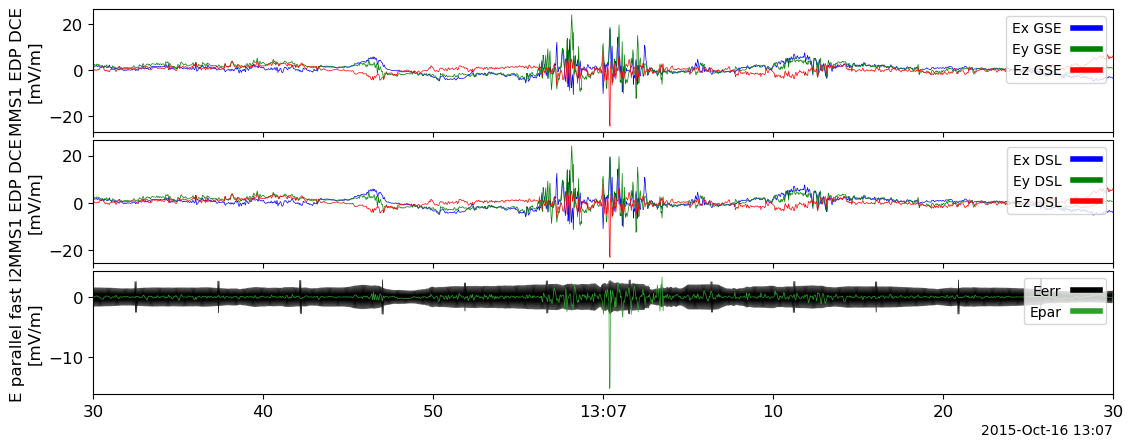

In [176]:
trangeOfInterest = ['2015-10-16T13:06:30', '2015-10-16T13:07:30']
tlimit(trangeOfInterest)
tplot(tvars)

## Offset

We choose a quite time by manually inspecting the data.

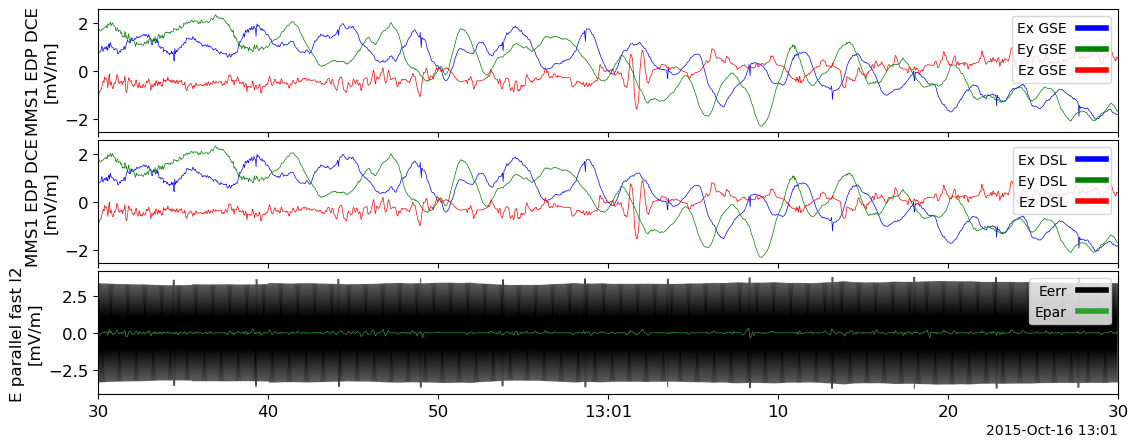

In [177]:
trange4offset = ['2015-10-16T13:00:30', '2015-10-16T13:01:30']
tlimit(trange4offset)
tplot(tvars)
tlimit(full=True)

In [193]:
e_tvar = 'mms1_edp_dce_dsl_fast_l2'
e_data : xr.DataArray = get_data(e_tvar, xarray=True)
offset = e_data.sel(time=slice(trange4offset[0], trange4offset[1])).mean(dim='time')
print('Ex offset =', offset[0].data)
print('Ey offset =', offset[1].data)

Ex offset = 0.23904572
Ey offset = 0.18106854


## $E_z$ component

We use the E*B=0 approximation to calculate $E_z$ component. And we ignore the differences (fractions of a degree) between DBCS, DMPA and DSL. [*](https://lasp.colorado.edu/galaxy/display/MFDPG/1.5+Coordinate+Systems)

28-Nov-23 17:14:28: Loading /Users/zijin/data/mms/mms1/fgm/srvy/l2/2015/10/mms1_fgm_srvy_l2_20151016_v4.18.0.cdf
28-Nov-23 17:14:30: Time clip was applied to: mms1_fgm_b_dmpa_srvy_l2
28-Nov-23 17:14:30: Time clip was applied to: mms1_fgm_flag_srvy_l2
28-Nov-23 17:14:30: Loaded variables:
28-Nov-23 17:14:30: mms1_fgm_b_dmpa_srvy_l2
28-Nov-23 17:14:30: mms1_fgm_b_dmpa_srvy_l2_bvec
28-Nov-23 17:14:30: mms1_fgm_b_dmpa_srvy_l2_btot
28-Nov-23 17:14:30: mms1_fgm_b_gse_srvy_l2_bvec
28-Nov-23 17:14:30: mms1_fgm_b_gse_srvy_l2_btot
28-Nov-23 17:14:30: mms1_fgm_b_gsm_srvy_l2_bvec
28-Nov-23 17:14:30: mms1_fgm_b_gsm_srvy_l2_btot
28-Nov-23 17:14:30: mms1_fgm_b_bcs_srvy_l2_bvec
28-Nov-23 17:14:30: mms1_fgm_b_bcs_srvy_l2_btot


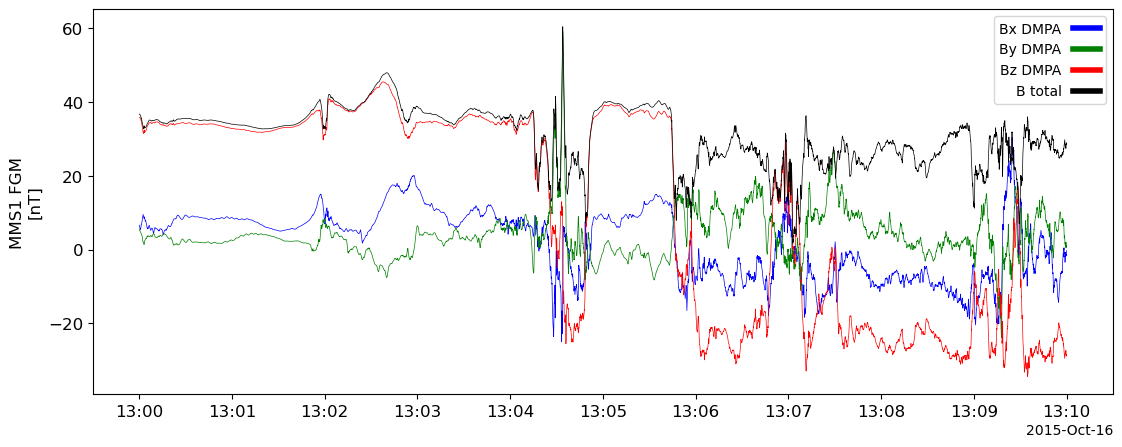

In [189]:
pyspedas.mms.fgm(trange=trange, time_clip=True, varformat='*dmpa*')
mag_tvar = 'mms1_fgm_b_dmpa_srvy_l2'
tplot(mag_tvar)

In [186]:
def calibrate_offset(data, offset):
    return data - offset

In [187]:
def calibrate_e_dot_b(e_data: xr.DataArray, mag_data, threshold_angle=10):
    data = e_data.copy()
    data[:, 2] = (
        -(e_data[:, 0] * mag_data[:, 0] + e_data[:, 1] * mag_data[:, 1])
        / mag_data[:, 2]
    )
    
    threshold = np.sin(np.deg2rad(threshold_angle))
    mask = np.abs((mag_data[:, 2] / mag_data[:, 3])) > threshold
    data[~mask] = np.nan
    
    return data

In [190]:
# Interpolate FGM data on EDP times
pyspedas.tinterpol(mag_tvar, e_tvar)
mag_data = get_data(mag_tvar + '-itrp', xarray=True)

e_data_c1 = calibrate_offset(e_data, offset)
e_data_c2 = calibrate_e_dot_b(e_data_c1, mag_data)


28-Nov-23 17:15:11: tinterpol (linear) was applied to: mms1_fgm_b_dmpa_srvy_l2-itrp


## Comparison

> Compare your estimate of Ez with the measurement of the same component made by the axial electric field boom pair. How large are the offsets for the axial field compared to those you have found for the spin plane components? 

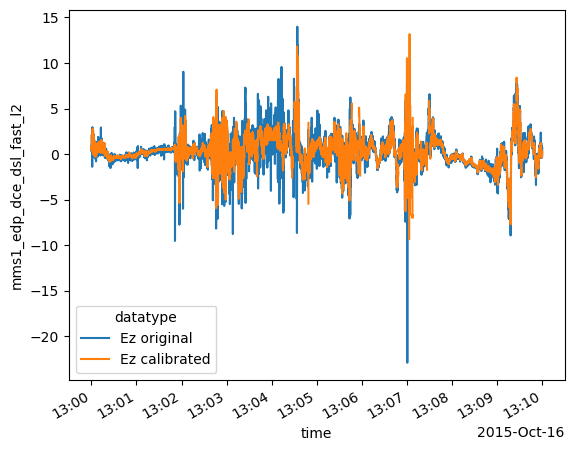

In [191]:
ez_data = e_data.sel(v_dim=2)
ez_data_c2 = e_data_c2.sel(v_dim=2)

xr.concat(
    [
        ez_data.assign_coords(datatype="Ez original"),
        ez_data_c2.assign_coords(datatype="Ez calibrated"),
    ],
    dim="datatype",
).plot(x="time", hue="datatype")

In [192]:
ez_offset = np.abs(ez_data - ez_data_c2).mean()
print("Ez offset = ", ez_offset.data)

Ez offset =  0.43761042
